# Compute success metrics

Use [the timescoring event-based success evaluation library](https://pypi.org/project/timescoring/) to detect how well your predicted cough locations match the ground-truth locations in the dataset in this illustrative example.

In [245]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import sys
import os
sys.path.append(os.path.abspath('../src'))
from helpers import *
from timescoring.annotations import Annotation
from timescoring import scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data
Load a sample cough recording and its ground truth annotation

In [246]:
data_folder = '../../data/public_dataset/' #Path to the public dataset location
subj_ids = os.listdir(data_folder)
subject = subj_ids[0]
sound = Sound.COUGH
trial = Trial.ONE
noise = Noise.NONE
mov = Movement.SIT

In [247]:
audio, _ = load_audio(data_folder, subject, trial, mov, noise, sound)
start_times, end_times = load_annotation(data_folder, subject, trial, mov, noise, sound)

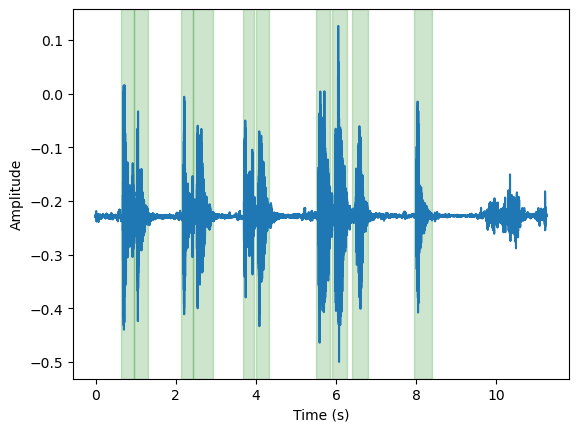

In [248]:
# Plot cough with ground-truth labels:
time = get_audio_time(audio)
plt.plot(time, audio)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
for (s,e) in zip (start_times, end_times):
    plt.axvspan(s,e,0,1, color="green", alpha=0.2)

In [249]:
# Load the predicted cough locations determined by your ML model
with open("example_prediction.json", "r") as f:
    dict = json.load(f)
start_times_pred = dict["start_times"]
end_times_pred = dict["end_times"]

## Set up event-based scoring parameters
The event-based scoring library used the following parameters to compute a final score:
* toleranceStart (float): Allow some tolerance on the start of an event without counting a false detection
* toleranceEnd (float): Allow some tolerance on the end of an event without counting a false detection
* minOverlap (float): Minimum relative overlap between reference and predected for a detection
* maxEventDuration (float): Automatically split events longer than a given duration
* minDurationBetweenEvents (float): Automatically merge events that are separated by less than the given duration.

We recommend using the values below:

In [250]:
toleranceStart = 0.25
toleranceEnd = 0.25
minOverlap = 0.1
maxEventDuration  = 0.6
minDurationBetweenEvents = 0

param = scoring.EventScoring.Parameters(toleranceStart, toleranceEnd, minOverlap, maxEventDuration, minDurationBetweenEvents)

In [251]:
# Generate tuples of (start,end) event times for the event-based scoring
events_true = []
for (s,e) in zip (start_times, end_times):
    events_true.append((s,e))
reference = Annotation(events_true, FS_IMU, round(len(audio)*FS_IMU/FS_AUDIO))

events_pred = []
for (s,e) in zip (start_times_pred, end_times_pred):
    events_pred.append((s,e))
prediction = Annotation(events_pred,  FS_IMU, round(len(audio)*FS_IMU/FS_AUDIO))

In [252]:
scores_evt = scoring.EventScoring(reference, prediction, param)
TP = scores_evt.tp
FP = scores_evt.fp
FN = scores_evt.refTrue - scores_evt.tp
SE = scores_evt.sensitivity
PR = scores_evt.precision
F1 = scores_evt.f1
print("There are {0} True Positive events, {1} False Positive events, and {2} False negative events.".format(TP, FP, FN))
print("The classifier has a Sensitivity of {0}, a Precision of {1}, and an F-1 score of {2} on this sample".format(SE, PR, F1))

There are 9 True Positive events, 1 False Positive events, and 1 False negative events.
The classifier has a Sensitivity of 0.9, a Precision of 0.9, and an F-1 score of 0.9 on this sample


### Calculate False Positives per Hour
In this toy example, we only use one short recording to measure the False Positives per hour of the classifier. In reality, this would be the combined number of false positives over multiple recordings or a long recording, divided by the total recording time.

In [259]:
hours_of_recording = len(audio)/(FS_AUDIO*3600)
FPhr = FP/hours_of_recording
print("False positives per hour: {0}".format(round(FPhr,2)))

False positives per hour: 319.91


### Visualize the true and predicted event labels

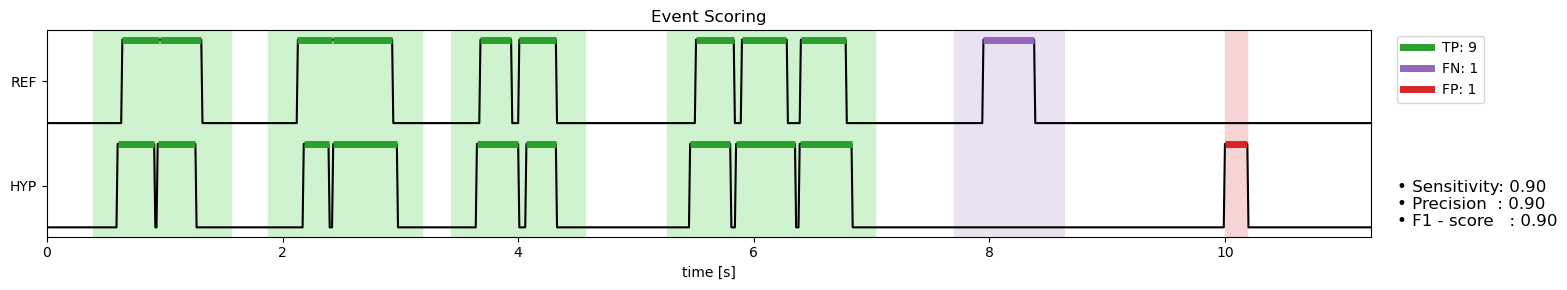

In [253]:
from timescoring import visualization
figEvents = visualization.plotEventScoring(reference, prediction, param)